In [44]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys

sys.path.append(os.path.abspath("../"))

import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from src.data_utils import create_training_dataset
from src.model_xg import train_and_plot
from src.utils import compute_auc_roc, evaluate_prediction

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)


load_dotenv()


from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import get_repo_root

scores = load_clean_scores(["2023-24"])
# scores = load_clean_scores()


# scores['outperform_next'] = scores.groupby('personId')['outperformed'].shift(-1)
scores.head(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,fantasyDiff,injured
390948,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,2544,lebron james,29.016667,10,16,0.625,1,4,0.25,0,1,0.0,1,7,8,5,1,0,0,1,21,7,40.50,49.35,0,1,-8.85,0
390949,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,11.60,0,0,-11.60,1
390950,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,202704,reggie jackson,24.066667,3,8,0.375,2,5,0.40,0,0,0.0,0,3,3,1,1,0,2,0,8,11,14.25,19.10,0,1,-4.85,0
390951,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,203076,anthony davis,34.150000,6,17,0.353,1,2,0.50,4,4,1.0,1,7,8,4,0,2,2,3,17,-17,36.00,51.80,0,1,-15.80,0
390952,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,203200,justin holiday,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,8.20,0,0,-8.20,1


In [40]:
# scores[scores.personId == 2544].head(20)

# Create Dataset

In [73]:
non_lag_features = ["plusMinusPoints", "injured"]
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = "outperformed"

training_dct = create_training_dataset(
    scores, non_lag_features, lag_features, target_col, diff_threshold=5
)

lagged_feat_names = training_dct["lagged_feat_names"]
full_df = training_dct["df"]

# Split training/validation sets
train_size = int(len(full_df) * 0.8)
train_df = full_df.iloc[:train_size]
test_df = full_df.iloc[train_size:]

# XGBoost

Sliding Window MAE: 16.920529858474286
Model MAE: 0.2514670348636521

Evaluation Metrics
----------------------------------------
Accuracy: 0.749
AUC (ROC): 0.743
F1 Score: 0.399
Precision: 0.553, Recall: 0.312

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[3854  390]
 [1067  483]]

Confusion Matrix (Percent of Column):
[[78.32 44.67]
 [21.68 55.33]]
----------------------------------------
AUC: 0.7428589127724909


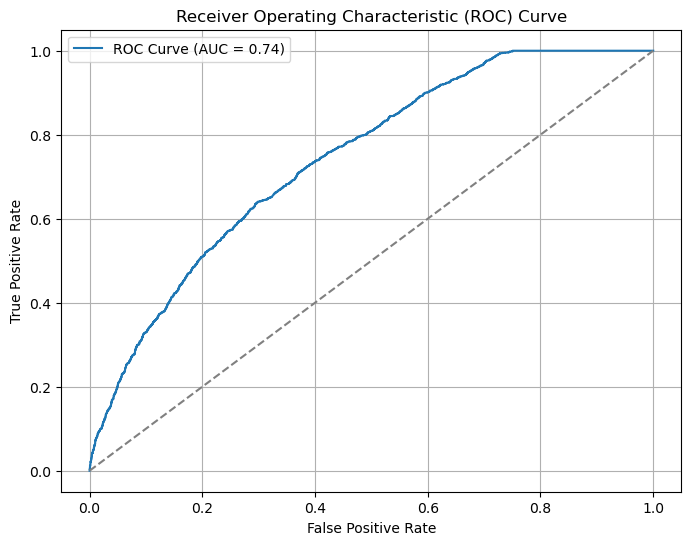

In [74]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

train_features = non_lag_features + lagged_feat_names
# train_features = lagged_feat_names

result_dct = train_and_plot(train_df, test_df, train_features, target_col)
y_probs = result_dct["y_prob"][:, 1]
y_preds = (y_probs >= 0.5).astype(int)
y_true = test_df[target_col]


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

# LSTM

## No Temporal Dependence

In [92]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        out = self.sigmoid(out)
        return out


class BasketballDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# non_lag_features = ["plusMinusPoints", "injured", "projectedFantasyPoints"]
feature_columns = ["plusMinusPoints", "injured", "projectedFantasyPoints"] + [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]
target_col = 'outperformed'
# target_col = 'outperform_next'

# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_columns])
test_features = scaler.transform(test_df[feature_columns])

# Convert target to numpy arrays
train_targets = train_df[target_col].values
test_targets = test_df[target_col].values

# Reshape data for LSTM (batch_size, sequence_length, num_features)
# Assume sequence_length = 1 (no temporal dependency in this case)
train_features = train_features[:, np.newaxis, :]
test_features = test_features[:, np.newaxis, :]

# Create datasets
train_dataset = BasketballDataset(train_features, train_targets)
test_dataset = BasketballDataset(test_features, test_targets)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
input_size = len(feature_columns)
hidden_size = 64
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.000002)

Epoch 1/10, Loss: 0.6889
Epoch 2/10, Loss: 0.6837
Epoch 3/10, Loss: 0.6786
Epoch 4/10, Loss: 0.6736
Epoch 5/10, Loss: 0.6685
Epoch 6/10, Loss: 0.6635
Epoch 7/10, Loss: 0.6585
Epoch 8/10, Loss: 0.6534
Epoch 9/10, Loss: 0.6483
Epoch 10/10, Loss: 0.6433

Evaluation Metrics
----------------------------------------
Accuracy: 0.744
AUC (ROC): 0.827
F1 Score: 0.599
Precision: 0.516, Recall: 0.715

Confusion Matrix:
TN, FP
FN, TP

Confusion Matrix (Counts):
[[3202 1042]
 [ 441 1109]]

Confusion Matrix (Percent of Column):
[[87.89 48.44]
 [12.11 51.56]]
----------------------------------------
AUC: 0.8274122860356936


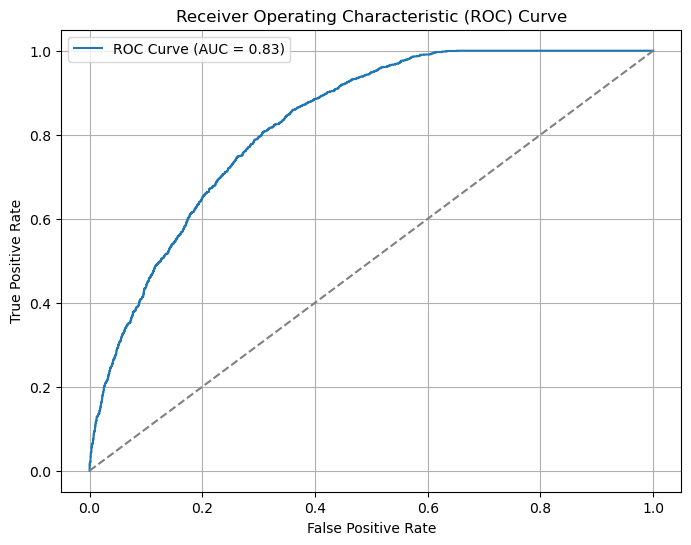

In [93]:
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")
    
model.eval()
y_probs = []
y_preds = []
y_true = []

prob_threshold = 0.5

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features).squeeze()
        predictions = (outputs > prob_threshold).float()
        y_probs.extend(outputs.numpy())
        y_preds.extend(predictions.numpy())
        y_true.extend(targets.numpy())


results = evaluate_prediction(y_true, y_probs, y_preds)

compute_auc_roc(
    y_true,
    y_probs,
)

## Train LSTM with Dependence

In [62]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, Dataset

# train_size = int(len(scores) * 0.8)
# train_df = scores.iloc[:train_size]
# test_df = scores.iloc[train_size:]

df_xg = scores

# Select only float and int columns as features
feature_columns = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

# Normalize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_columns])
test_features = scaler.transform(test_df[feature_columns])

sequence_length = 3
target_column = "outperformed"

# Prepare sequences for each player
sequences = []
targets = []

grouped = df_xg.groupby("personId")
for _, group in grouped:
    group = group.reset_index(drop=True)
    for i in range(len(group) - sequence_length + 1):
        # Extract the sequence of features for the last `sequence_length` timesteps
        seq_features = group.iloc[i : i + sequence_length][feature_columns].values
        seq_target = group.iloc[i + sequence_length - 1][
            target_column
        ]  # Target corresponds to the last timestep
        sequences.append(seq_features)
        targets.append(seq_target)

# Convert to numpy arrays
sequences = np.array(sequences)
targets = np.array(targets)

# Train-test split
train_size = int(len(sequences) * 0.8)
train_sequences, test_sequences = sequences[:train_size], sequences[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]

In [64]:
class BasketballDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]


# Create datasets
train_dataset = BasketballDataset(train_sequences, train_targets)
test_dataset = BasketballDataset(test_sequences, test_targets)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM forward pass
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        out = self.sigmoid(out)  # Binary classification
        return out


# Initialize the model
input_size = len(feature_columns)  # Number of features per timestep
hidden_size = 64
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for sequences, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(sequences).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

model.eval()
y_probs = []
y_preds = []
y_true = []

with torch.no_grad():
    for sequences, targets in test_loader:
        outputs = model(sequences).squeeze()
        predictions = (outputs > 0.5).float()
        y_probs.extend(outputs.numpy())
        y_preds.extend(predictions.numpy())
        y_true.extend(targets.numpy())

results = evaluate_prediction(y_true, y_probs, y_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {roc_auc:.4f}")

Epoch 1/10, Loss: 0.3697
Epoch 2/10, Loss: 0.2925
Epoch 3/10, Loss: 0.2832
Epoch 4/10, Loss: 0.2792
Epoch 5/10, Loss: 0.2756
Epoch 6/10, Loss: 0.2742
Epoch 7/10, Loss: 0.2715
Epoch 8/10, Loss: 0.2716
Epoch 9/10, Loss: 0.2709
Epoch 10/10, Loss: 0.2685


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (192,) + inhomogeneous part.

In [67]:
len(y_probs)

192

In [68]:
y_probs[0].shape

(32,)

In [69]:
len(y_true)

6130

In [79]:
accuracy_score(all_targets[:20], all_preds[:20])

0.9

In [78]:
all_preds[:20]

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0]

Sliding Window MAE: 17.342107983364983
Model MAE: 0.29808408855982116
AUC: 0.7932798184313165


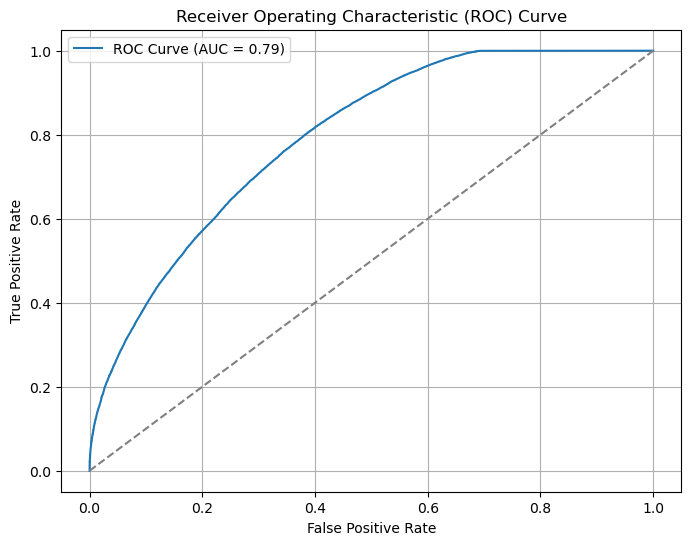

0.7932798184313165

In [48]:
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

df_xg, new_feats = add_lagged_features(scores, lag_features, 5)
df_xg = df_xg.assign(outperformed=np.where(df_xg["fantasyDiff"] > 0, 1, 0))
df_xg = df_xg.assign(
    actual_minutes_increased=np.where(df_xg["minutes"] > df_xg["minutes_lag_1"], 1, 0)
)

df_xg = df_xg.dropna()


# select_features = ["plusMinusPoints", "projectedFantasyPoints", "injured"] + new_feats
select_features = ["plusMinusPoints", "injured", "projectedFantasyPoints"] + new_feats
target_col = "outperformed"
# target_col = "fantasyPoints"

# Split training/validation sets
train_size = int(len(df_xg) * 0.8)
train_df = df_xg.iloc[:train_size]
test_df = df_xg.iloc[train_size:]


result_dct = train_and_plot(train_df, test_df, select_features, target_col)
y_pred = result_dct["y_prob"]
binary_predict = y_pred[:, 1]
# y_pred = result_dct["y_pred"]

# binary_predict = np.where(y_pred > test_df['projectedFantasyPoints'], 1, 0)
# binary_predict = np.where(y_pred > 0, 1, 0)

compute_auc_roc(
    test_df["outperformed"],
    binary_predict,
)

In [44]:
X_train = result_dct["x_train"]
model = result_dct["model"]

feature_importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)
importance_df

,Feature,Importance
2,injured,0.486270
0,plusMinusPoints,0.061344
6,minutes_lag_4,0.020694
8,fieldGoalsAttempted_lag_1,0.016498
5,minutes_lag_3,0.016217
7,minutes_lag_5,0.011795
4,minutes_lag_2,0.011193
25,threePointersPercentage_lag_3,0.010709
3,minutes_lag_1,0.010377
63,turnovers_lag_1,0.009780


In [86]:
first_cols = ["outperformed", "predict"]

d = test_df.assign(predict=y_pred)
d[[c for c in d.columns if not "lag" in c]]

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,actual_minutes_increased,predict
362391,2022-23,2022-10-27,22200068,MIA @ GSW,heat,heat,2617,udonis haslem,0.000000,0,0,0.000,0,0,0.000,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0.00,0.65,0,0,0
362392,2022-23,2022-10-27,22200068,MIA @ GSW,heat,heat,200768,kyle lowry,33.133333,4,10,0.400,2,8,0.250,2,2,1.00,1,4,5,8,3,0,2,4,12,-9,35.25,25.50,1,1,1
362395,2022-23,2022-10-27,22200068,MIA @ GSW,heat,heat,202710,jimmy butler,37.050000,8,13,0.615,4,7,0.571,7,7,1.00,1,5,6,8,6,0,2,2,27,-8,57.50,37.80,1,1,0
362398,2022-23,2022-10-27,22200068,MIA @ GSW,heat,heat,203473,dewayne dedmon,0.000000,0,0,0.000,0,0,0.000,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0.00,5.70,0,0,0
362401,2022-23,2022-10-27,22200068,MIA @ GSW,heat,heat,1628389,bam adebayo,37.733333,10,13,0.769,0,0,0.000,6,8,0.75,4,4,8,1,4,3,5,2,26,-12,49.00,30.50,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412239,2023-24,2024-02-08,22300733,IND vs. GSW,pacers,pacers,1630188,jalen smith,13.316667,6,6,1.000,2,2,1.000,0,0,0.00,3,2,5,0,1,0,0,1,14,3,22.25,18.25,1,0,1
412240,2023-24,2024-02-08,22300733,GSW @ IND,warriors,warriors,1630228,jonathan kuminga,33.433333,9,16,0.563,0,2,0.000,0,0,0.00,1,1,2,4,0,2,3,1,18,20,29.00,40.15,0,1,1
412241,2023-24,2024-02-08,22300733,GSW @ IND,warriors,warriors,1630541,moses moody,13.483333,2,3,0.667,1,1,1.000,0,0,0.00,0,3,3,1,2,1,1,1,5,8,15.75,15.95,0,0,1
412242,2023-24,2024-02-08,22300733,IND vs. GSW,pacers,pacers,1630543,isaiah jackson,10.716667,1,2,0.500,0,0,0.000,2,2,1.00,1,2,3,2,1,0,0,1,4,-12,12.75,7.20,1,1,1


## Load Podcast Data

In [4]:
from src.data_utils import PodcastContainer

cont = PodcastContainer(
    {
        "rotowire": PodcastContainer.ROTOWIRE_DIR,
        # "nbatoday": PodcastContainer.NBATODAY_DIR,
    }
)
pod_df = cont.get_all_episodes()
pod_df = pod_df[pod_df.file_name.str.contains("week_15")]
pod_df

,publication_date,file_name,file_path,content,duration,podcast_name
56,2024-01-26,fantasy_basketball_waiver_wire_for_week_15_202324,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome everybody to the award winning rotor w...,2839,rotowire


## Extract LLM Features and Plot as a Predictor

In [5]:
from sklearn.model_selection import train_test_split
from src.llm_feature_extractor import FaissFeatureExtractor
from src.model_xg import add_lagged_features
from xgboost import XGBRegressor

# Extract features
faiss_fe = FaissFeatureExtractor()
feats = faiss_fe.extract_llm_feats(pod_df)

C:\Users\Patrick\My Drive\Columbia\Practical Deep Learning\FantasyPodcastInsights\src\llm_feature_extractor.py:320: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  self.embeddings_model = OpenAIEmbeddings()
0it [00:00, ?it/s]

Loading from disk: chunk_embeddings.pkl
Loading from disk: player_chunk_mapping.pkl


1it [00:46, 46.10s/it]


In [10]:
lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

df_xg, new_feats = add_lagged_features(scores, lag_features, 5)
df_xg = df_xg.assign(outperformed=np.where(df_xg["outperformed"], 1, 0))
df_xg = df_xg.assign(
    actual_minutes_increased=np.where(df_xg["minutes"] > df_xg["minutes_lag_1"], 1, 0)
)

df_xg = df_xg.dropna()

# Merge with LLM features
df_xg = pd.merge_asof(
    df_xg,
    feats,
    left_on="game_date",
    right_on="podcast_date",
    by="personName",
    tolerance=pd.Timedelta("5d"),
)
df_xg = df_xg.dropna()

# Split training/validation sets
train_size = int(len(df_xg) * 0.8)
train_df = df_xg.iloc[train_size:]
test_df = df_xg.iloc[:train_size]

print(f"rows: {len(df_xg)}")
print(df_xg["increased_playing_time"].describe())

rows: 194
count    194.000000
mean       0.079639
std        0.247182
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.800000
Name: increased_playing_time, dtype: float64


AUC: 0.5319510898458266


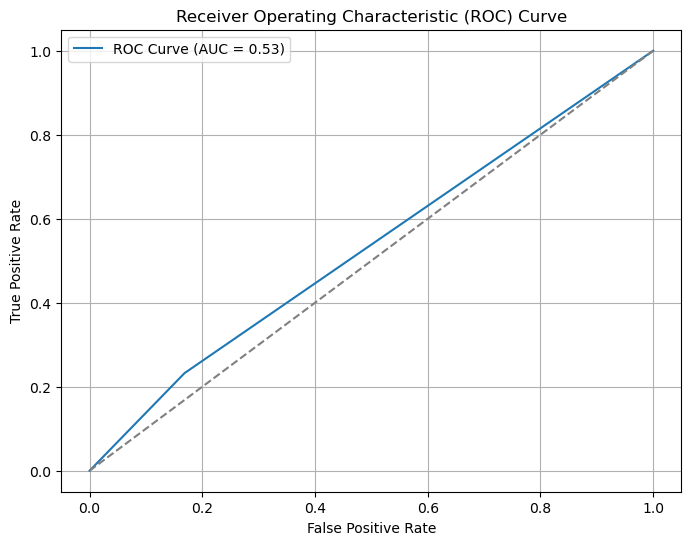

Confusion Matrix:
[[79 16]
 [76 23]]
[[40.72164948  8.24742268]
 [39.17525773 11.8556701 ]]


In [31]:
# ---- Plot AUC of the feature only ---
from sklearn.metrics import confusion_matrix
from src.utils import compute_auc_roc

d = df_xg[["outperformed", "increased_playing_time", "actual_minutes_increased"]]

ground_truth = d["actual_minutes_increased"]
predicted_classes = np.where(d["increased_playing_time"] > 0, 1, 0)

# # compute_auc_roc(d["outperformed"], d["playing_time"])
compute_auc_roc(ground_truth, predicted_classes)

cm = confusion_matrix(ground_truth, predicted_classes)
print("Confusion Matrix:")
print(cm)


total_samples = cm.sum()
conf_matrix_total_percent = (cm / total_samples) * 100
print(conf_matrix_total_percent)

In [32]:
# TN, FP
# FN, TP

## Train XGBoost with LLM Features

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,actual_minutes_increased,podcast_name,podcast_date,increased_playing_time
45899,2023-24,2024-01-26,22300634,DAL @ ATL,mavericks,mavericks,203501,tim hardaway jr,32.150000,3,12,0.250,3,9,0.333,4,4,1.000,1,3,4,3,0,0,2,2,13,-5,21.50,29.55,0,34.266667,31.95,28.283333,40.633333,39.333333,16.0,13.0,17.0,23.0,17.0,0.375,0.615,0.294,0.478,0.471,10.0,7.0,7.0,15.0,...,6.0,0.500,0.000,1.000,1.000,0.833,5.0,2.0,2.0,2.0,4.0,5.0,2.0,4.0,2.0,4.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,1.0,2.0,2.0,0.0,3.0,17.0,20.0,12.0,41.0,24.0,0,rotowire,2024-01-26,0.0
45902,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203991,clint capela,24.566667,4,7,0.571,0,0,0.000,2,3,0.667,3,5,8,2,0,1,1,2,10,-7,24.50,25.30,0,24.666667,22.00,22.100000,22.216667,27.300000,9.0,10.0,8.0,4.0,6.0,0.333,0.400,0.375,0.500,1.000,0.0,0.0,0.0,0.0,...,0.0,0.714,0.750,0.000,0.714,0.000,8.0,6.0,4.0,6.0,3.0,11.0,12.0,9.0,11.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,2.0,2.0,3.0,11.0,11.0,6.0,9.0,12.0,0,rotowire,2024-01-26,0.0
45903,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203992,bogdan bogdanovic,27.266667,9,22,0.409,4,9,0.444,2,2,1.000,2,2,4,2,2,0,0,2,24,3,36.00,23.05,1,32.516667,33.60,28.333333,34.916667,23.916667,11.0,12.0,11.0,15.0,7.0,0.545,0.417,0.455,0.400,0.571,9.0,8.0,6.0,7.0,...,2.0,1.000,1.000,0.750,1.000,1.000,0.0,2.0,2.0,3.0,3.0,0.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,0.0,2.0,1.0,17.0,18.0,14.0,17.0,12.0,0,rotowire,2024-01-26,0.0
45905,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1627749,dejounte murray,37.050000,9,18,0.500,3,7,0.429,1,2,0.500,1,4,5,7,0,0,3,3,22,-21,37.25,46.60,0,33.216667,40.10,34.716667,39.766667,36.033333,19.0,23.0,19.0,22.0,18.0,0.368,0.478,0.526,0.409,0.611,7.0,10.0,7.0,7.0,...,3.0,0.875,0.875,1.000,1.000,1.000,4.0,10.0,9.0,3.0,4.0,7.0,10.0,9.0,3.0,5.0,7.0,6.0,5.0,11.0,5.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,5.0,2.0,1.0,2.0,2.0,1.0,23.0,35.0,24.0,22.0,26.0,1,rotowire,2024-01-26,0.0
45907,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1629027,trae young,33.183333,9,18,0.500,2,7,0.286,10,11,0.909,0,1,1,11,3,0,2,3,30,9,54.25,39.75,1,28.300000,38.70,37.600000,36.150000,

Sliding Window MAE: 30.017096774193547
Model MAE: 0.25161290322580643
AUC: 0.7458333333333332


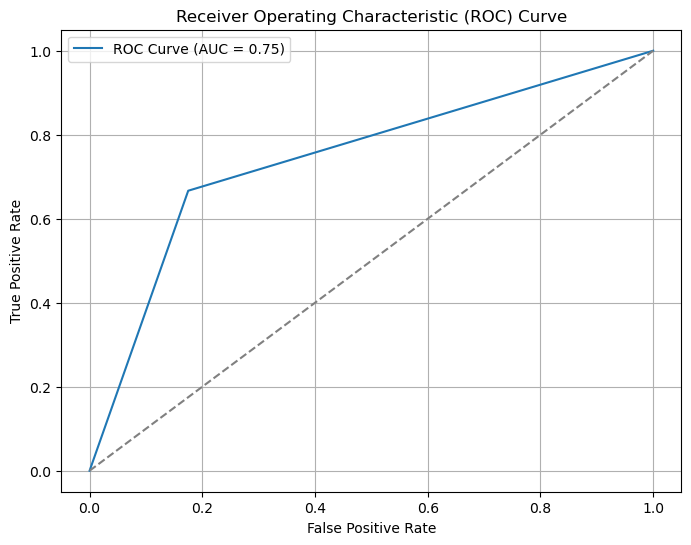

0.7458333333333332

In [68]:
llm_features = ["increased_playing_time"]
select_features = ["plusMinusPoints", "fantasyPoints"] + llm_features + new_feats
# target_col = "fantasyPoints"
target_col = "outperformed"

result_dct = train_and_plot(train_df, test_df, select_features, target_col)
y_pred = result_dct["y_pred"]

compute_auc_roc(
    test_df["outperformed"],
    np.where(y_pred > 0, 1, 0),
)

## Train Baseline Model

In [58]:
# XGBoosting.com
# Fit an XGBoost Model for Binary Classification using scikit-learn API
from sklearn.datasets import make_classification
from xgboost import XGBClassifier

# Generate a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

# Initialize XGBClassifier
model = XGBClassifier(objective="binary:logistic", random_state=42)

# Fit the model to training data
model.fit(X, y)

# Make predictions with the fit model
predictions = model.predict(X)
print(predictions[:5])

[0 0 0 1 1]


In [57]:
X.shape

(1000, 20)

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,actual_minutes_increased,podcast_name,podcast_date,increased_playing_time
45899,2023-24,2024-01-26,22300634,DAL @ ATL,mavericks,mavericks,203501,tim hardaway jr,32.150000,3,12,0.250,3,9,0.333,4,4,1.000,1,3,4,3,0,0,2,2,13,-5,21.50,29.55,0,34.266667,31.95,28.283333,40.633333,39.333333,16.0,13.0,17.0,23.0,17.0,0.375,0.615,0.294,0.478,0.471,10.0,7.0,7.0,15.0,...,6.0,0.500,0.000,1.000,1.000,0.833,5.0,2.0,2.0,2.0,4.0,5.0,2.0,4.0,2.0,4.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,1.0,2.0,2.0,0.0,3.0,17.0,20.0,12.0,41.0,24.0,0,rotowire,2024-01-26,0.0
45902,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203991,clint capela,24.566667,4,7,0.571,0,0,0.000,2,3,0.667,3,5,8,2,0,1,1,2,10,-7,24.50,25.30,0,24.666667,22.00,22.100000,22.216667,27.300000,9.0,10.0,8.0,4.0,6.0,0.333,0.400,0.375,0.500,1.000,0.0,0.0,0.0,0.0,...,0.0,0.714,0.750,0.000,0.714,0.000,8.0,6.0,4.0,6.0,3.0,11.0,12.0,9.0,11.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,2.0,2.0,3.0,11.0,11.0,6.0,9.0,12.0,0,rotowire,2024-01-26,0.0
45903,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,203992,bogdan bogdanovic,27.266667,9,22,0.409,4,9,0.444,2,2,1.000,2,2,4,2,2,0,0,2,24,3,36.00,23.05,1,32.516667,33.60,28.333333,34.916667,23.916667,11.0,12.0,11.0,15.0,7.0,0.545,0.417,0.455,0.400,0.571,9.0,8.0,6.0,7.0,...,2.0,1.000,1.000,0.750,1.000,1.000,0.0,2.0,2.0,3.0,3.0,0.0,2.0,2.0,3.0,4.0,3.0,4.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,0.0,2.0,1.0,17.0,18.0,14.0,17.0,12.0,0,rotowire,2024-01-26,0.0
45905,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1627749,dejounte murray,37.050000,9,18,0.500,3,7,0.429,1,2,0.500,1,4,5,7,0,0,3,3,22,-21,37.25,46.60,0,33.216667,40.10,34.716667,39.766667,36.033333,19.0,23.0,19.0,22.0,18.0,0.368,0.478,0.526,0.409,0.611,7.0,10.0,7.0,7.0,...,3.0,0.875,0.875,1.000,1.000,1.000,4.0,10.0,9.0,3.0,4.0,7.0,10.0,9.0,3.0,5.0,7.0,6.0,5.0,11.0,5.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,4.0,2.0,2.0,5.0,2.0,1.0,2.0,2.0,1.0,23.0,35.0,24.0,22.0,26.0,1,rotowire,2024-01-26,0.0
45907,2023-24,2024-01-26,22300634,ATL vs. DAL,hawks,hawks,1629027,trae young,33.183333,9,18,0.500,2,7,0.286,10,11,0.909,0,1,1,11,3,0,2,3,30,9,54.25,39.75,1,28.300000,38.70,37.600000,36.150000,

Sliding Window MAE: 30.017096774193547
Model MAE: 0.25161290322580643
AUC: 0.7458333333333332


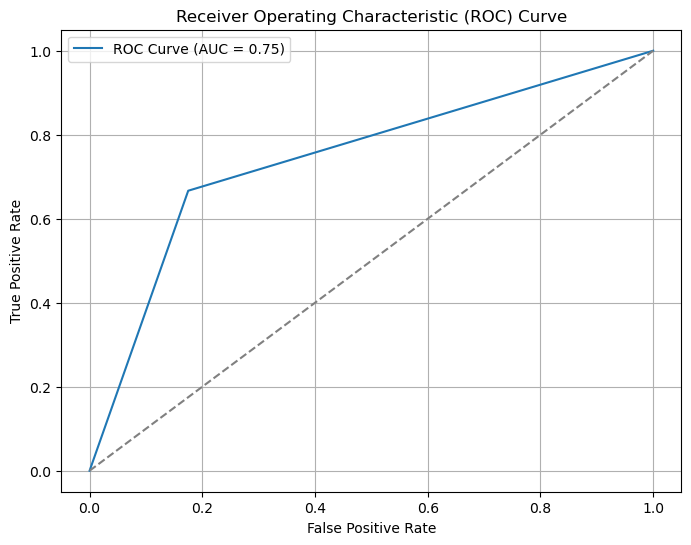

0.7458333333333332

In [63]:
select_features = ["plusMinusPoints", "fantasyPoints"] + new_feats
# target_col = "fantasyPoints"
target_col = "outperformed"

result = train_and_plot(train_df, test_df, select_features, target_col)
y_pred = result["y_pred"]

compute_auc_roc(
    test_df["outperformed"],
    np.where(y_pred > 0, 1, 0),
)

# compute_auc_roc(
#     test_df["outperformed"],
#     np.where(y_pred < 0, 1, 0),
# )

In [19]:
feature_importances = result["model"].feature_importances_
feature_names = select_features

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)
importance_df

,Feature,Importance
8,fieldGoalsAttempted_lag_2,2.458510e-01
43,reboundsTotal_lag_2,1.766159e-01
60,blocks_lag_4,1.668557e-01
38,reboundsDefensive_lag_2,9.579321e-02
18,threePointersAttempted_lag_2,5.333487e-02
7,fieldGoalsAttempted_lag_1,4.308774e-02
28,freeThrowsAttempted_lag_2,2.568356e-02
42,reboundsTotal_lag_1,2.399167e-02
11,fieldGoalsAttempted_lag_5,2.099735e-02
68,foulsPersonal_lag_2,1.927165e-02
